In [8]:
%matplotlib notebook
import numpy as np
import scipy as sp
from scipy.linalg import expm 
import matplotlib.pyplot as plt

from importlib import import_module, reload

In [2]:
eg = import_module('SpringMassDamper')
DMD = import_module('DMD')

In [28]:
eg = reload(eg)
DMD = reload(DMD)

In [4]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color'] # store color array

# Sine example

Here we show off the importance of delay embeddings.

If a real-valued operator A doesn't have sufficient dimensionality, then it cannot produce the necessary complex conjugate pair of roots required to produce oscillatory time dynamics. For example, suppose we are measuring a 1D sine wave. The DMD operator A would have only one real root. The operator must be augmented to capture the oscillation.

<IPython.core.display.Javascript object>


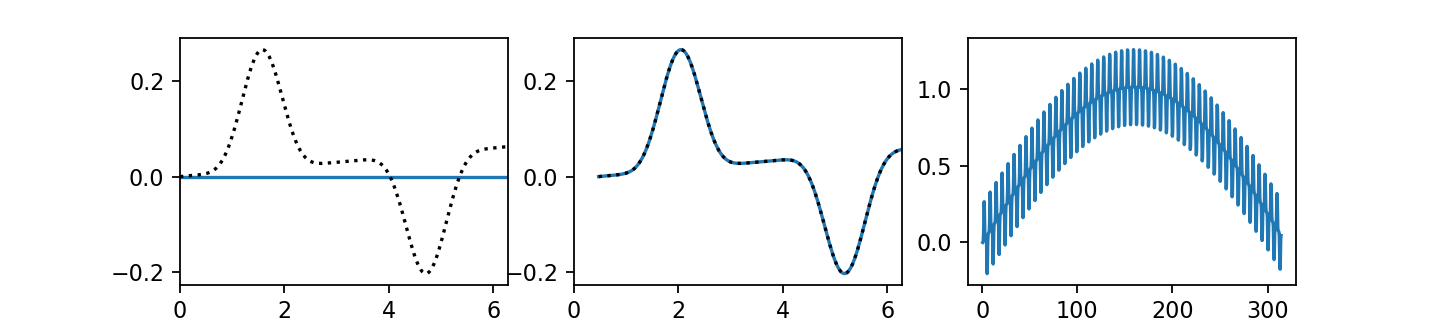

<IPython.core.display.Javascript object>


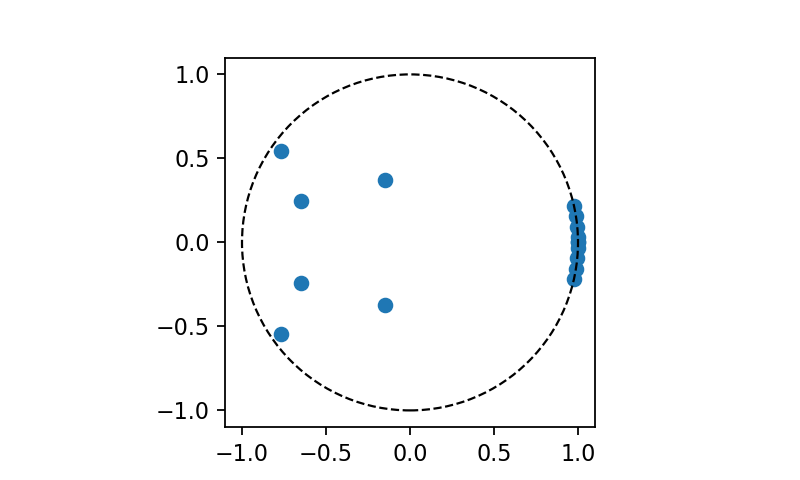

In [5]:
fig, axes = plt.subplots(1, 3, figsize=[9,2])

ts = np.linspace(0,2*np.pi, 200)
data = np.sin(1e-2*ts) + 0.25*np.sin(ts)**7 # powers -> add'l freq for each extra power
data = data.reshape(1,-1)

# 1 - Regular DMD
dmd = DMD.DMD.from_full(data, ts)
axes[0].plot(ts, dmd.predict(ts)[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0], ls=':', c='k')
axes[0].set_xlim([0,2*np.pi])

# 2- Delay embed
shift = 15 # shift + 1 is number of eigenvalues (2*7 + 2)
ts1 = ts[shift:]
dmd = DMD.DMD.from_full(DMD.delay_embed(data, shift), ts[shift:])

axes[1].plot(ts1, dmd.predict(ts1)[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0], ls=':', c='k')
axes[1].set_xlim([0,2*np.pi])

# plot long times (captures low frequency, too)
ts = np.linspace(ts1[0],1e2*np.pi, 1000)
axes[2].plot(ts, dmd.predict(ts)[0].real, c=color[0])

# toss in an eigenvalue plot at the end
DMD.plot_eigs(dmd.eigs, figsize=[5,3]);

Keeping with sine, let's address the addition of noise and the importance of thresholding.

<IPython.core.display.Javascript object>


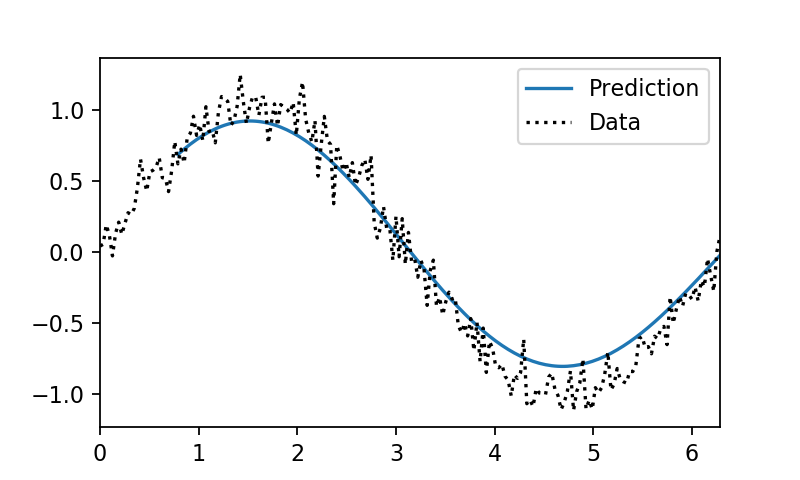

<IPython.core.display.Javascript object>


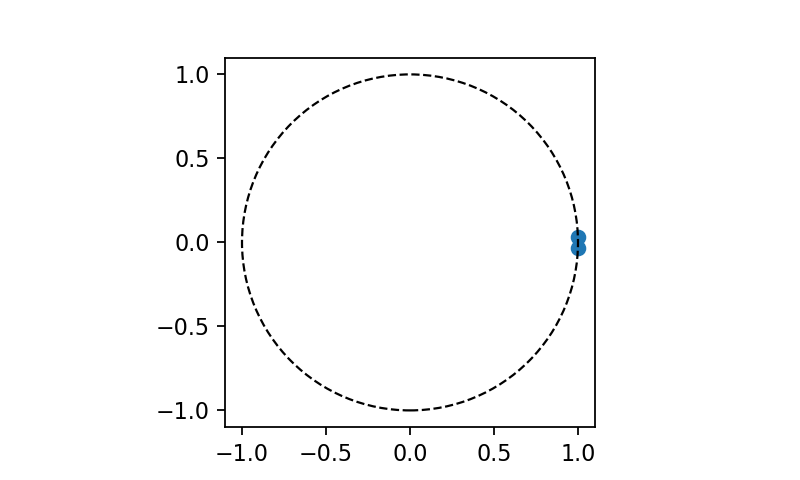

In [6]:
fig, ax = plt.subplots(1,1, figsize=[5,3])

ts = np.linspace(0,2*np.pi, 200)
data = np.sin(ts) + .1*np.random.randn(len(ts))
data = data.reshape(1,-1)

# 2- Delay embed
shift = 25
ts1 = ts[shift:]
dmd = DMD.DMD.from_full(DMD.delay_embed(data, shift), ts[shift:], threshold=2, threshold_type='count')

ax.plot(ts1, dmd.predict(ts1)[-1].real, c=color[0], label='Prediction')
ax.plot(ts, data[0], ls=':', c='k', label='Data')
ax.set_xlim([0,2*np.pi])
ax.legend()

DMD.plot_eigs(dmd.eigs, figsize=[5,3]);

Use the average DMD operator to correct for noisey errors.

<IPython.core.display.Javascript object>


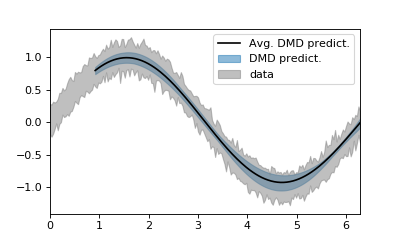

(0, 6.283185307179586)

In [8]:
dmdA_list = []
data_list = []
predict_list = []
for aModel in range(50):
    ts = np.linspace(0,2*np.pi, 200)
    data = np.sin(ts) + .1*np.random.randn(len(ts))
    data_list.append(data)
    data = data.reshape(1,-1)
    
    # 2- Delay embed
    shift = 29
    dmd = DMD.DMD.from_full(DMD.delay_embed(data, shift), ts[shift:], threshold=2, threshold_type='count')
    predict_list.append(dmd.predict(ts[shift:])[-1].real)
    dmdA_list.append(dmd.A)
data_list = np.array(data_list)
predict_list = np.array(predict_list)

A = np.mean(dmdA_list,axis=0)
ctsA, _ = DMD.cts_from_dst(A, np.zeros_like(A), ts[1]-ts[0])
A_predict = [(expm(ctsA*t)@dmd.X1[:,0]).real[0] for t in ts[shift:]]

fig, ax = plt.subplots(1,1, figsize=[5,3])
ax.plot(ts[shift:], A_predict,  c='k', label='Avg. DMD predict.')
ax.fill_between(ts[shift:], np.min(predict_list, axis=0), np.max(predict_list, axis=0),
                alpha=0.5, color=color[0], label='DMD predict.')
ax.fill_between(ts, np.min(data_list, axis=0), np.max(data_list, axis=0), 
                alpha=0.5, color='gray', label='data')
ax.legend()
ax.set_xlim([0,2*np.pi])

# Spring-Mass-Damper example

We'll show how DMD works with a physical system where we have intuition for forcing.

In [9]:
# Initialize system
smd = eg.spring_mass_damper({'mass': 10, 'spring': 1, 'damper': 1})
y0 = np.array([0, 2]) # kick it

# Choose times (these are universally used throughout this section for the control pulse)
t_span = [0,100]
dt = .1
ts = np.linspace(*t_span, 1000)

First, compute the transfer function for a linear state space system under forcing. We'll plot the transfer function to find interesting frequencies by inspection

<IPython.core.display.Javascript object>


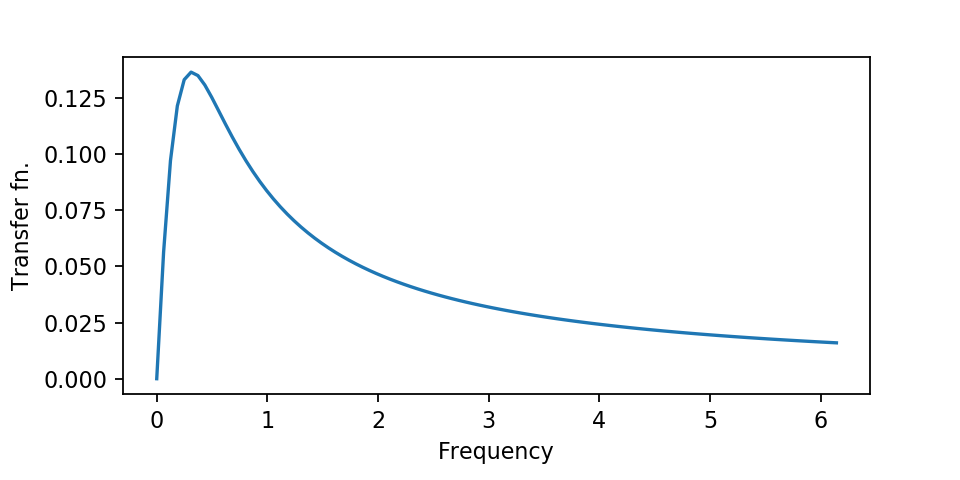

<IPython.core.display.Javascript object>


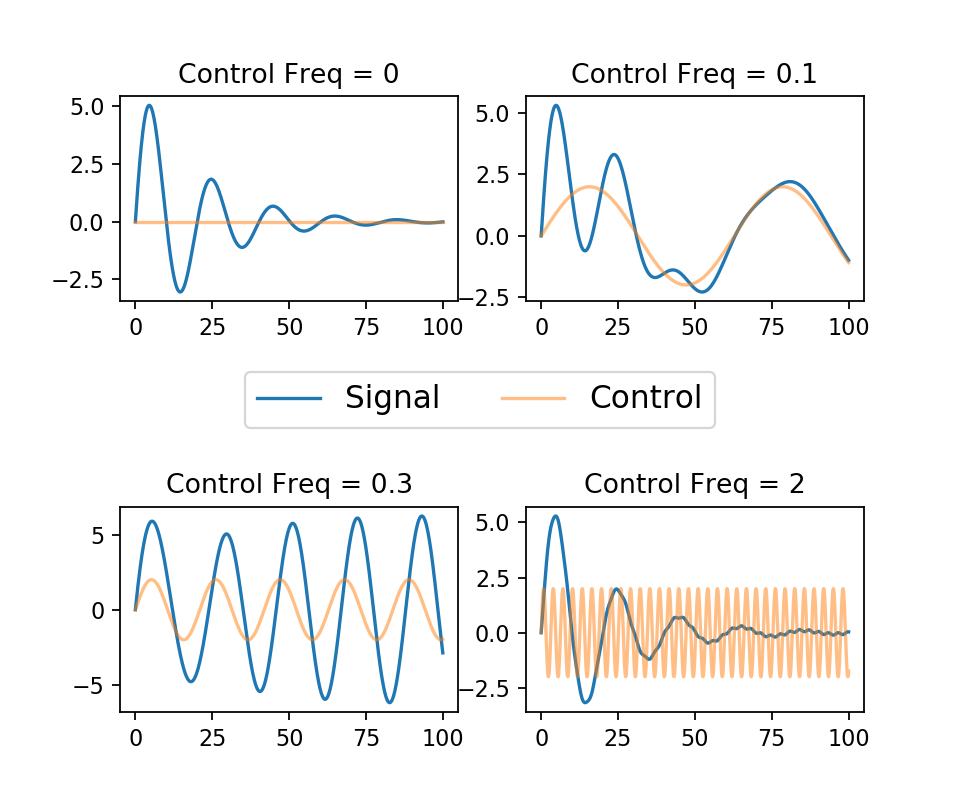

In [10]:
# Transfer function for a linear state space system
G = lambda s: np.linalg.inv(s%(2*np.pi)*np.identity(2)-smd.A)@smd.B

fig, ax = plt.subplots(1, figsize=[6,3])
fig.tight_layout(rect=[0.05,0.05,.95,.95])
freq = np.linspace(0, 43/7, 100)
ax.plot(freq, [G(s)[1] for s in freq])
ax.set_xlabel('Frequency')
ax.set_ylabel('Transfer fn.')

# Plot some frequencies
fig, axes = plt.subplots(2,2,figsize=[6,5])
fig.subplots_adjust(hspace=1)
for ax, freq in zip(axes.flatten(), [0,.1,.3,2]):
    # Run simulation
    smd.set_control(ts, 2*np.sin(freq*ts))
    res = smd.simulate(y0, t_span, dt, True)
    
    # Plot result
    ax.set_title('Control Freq = {}'.format(freq))
    ax.plot(smd.t, smd.x)
    ax.plot(smd.t, smd.u(smd.t), alpha=0.5)
    
fig.legend(['Signal', 'Control'], fontsize=14, loc='center', ncol=2)

Let's look at the SMD without any external forcing. This example will show how time delays are similar to including a measured derivative term. (From left to right, we have DMD default, DMD only measuring position, and DMD with a time delay to capture position and it's derivative).

<IPython.core.display.Javascript object>


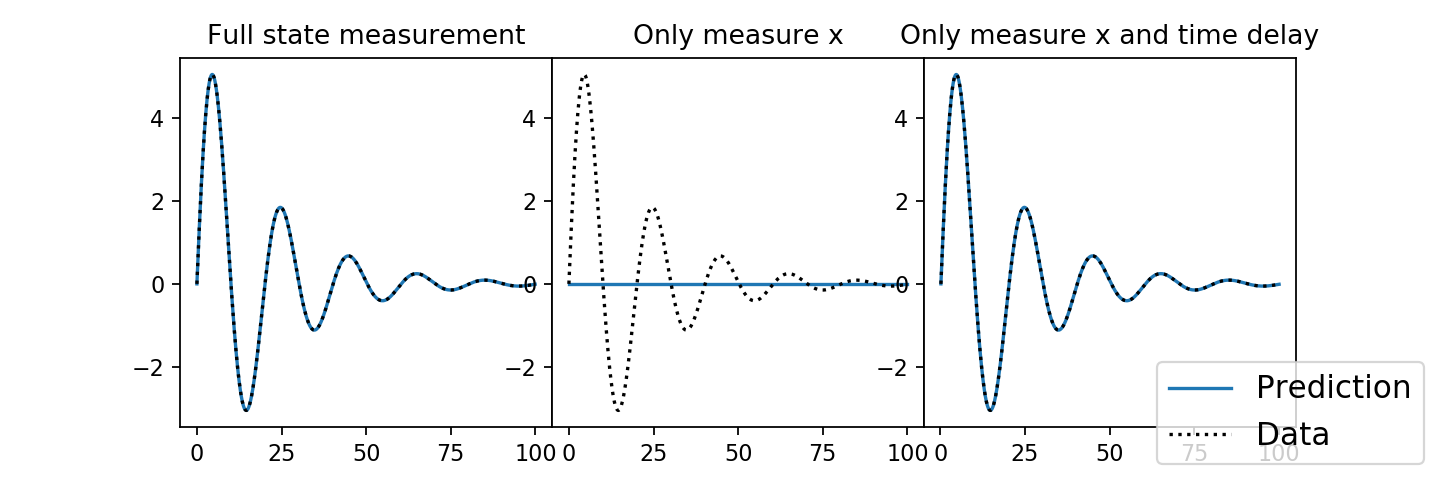

In [11]:
fig, axes = plt.subplots(1,3, figsize=[9,3])
fig.subplots_adjust(wspace=0)

omega = 0 # no control
smd.set_control(ts, 2*np.sin(omega*ts))
res = smd.simulate(y0, t_span, dt, True)

# Default
dmd = DMD.DMD.from_full(res.y, res.t)
axes[0].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0], ls=':', c='k')
axes[0].set_title('Full state measurement')

# Only measure x:
dmd = DMD.DMD.from_full(res.y[0,:].reshape(1,-1), res.t)
axes[1].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0], ls=':', c='k')
axes[1].set_title('Only measure x')

# Only measure x and time-delay
s = 1
dmd = DMD.DMD.from_full(DMD.delay_embed(res.y[0,:].reshape(1,-1), s), res.t[2:])
axes[2].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[2].plot(dmd.orig_timesteps, dmd.X1[0], ls=':', c='k')
axes[2].set_title('Only measure x and time delay')


fig.legend(['Prediction', 'Data'], fontsize=14, loc='lower right', ncol=1)

Next, let's just inspect an example where the control is nonlinear. Can we capture the dynamics with regular DMD? Yes, if we time-delay enough.

<IPython.core.display.Javascript object>


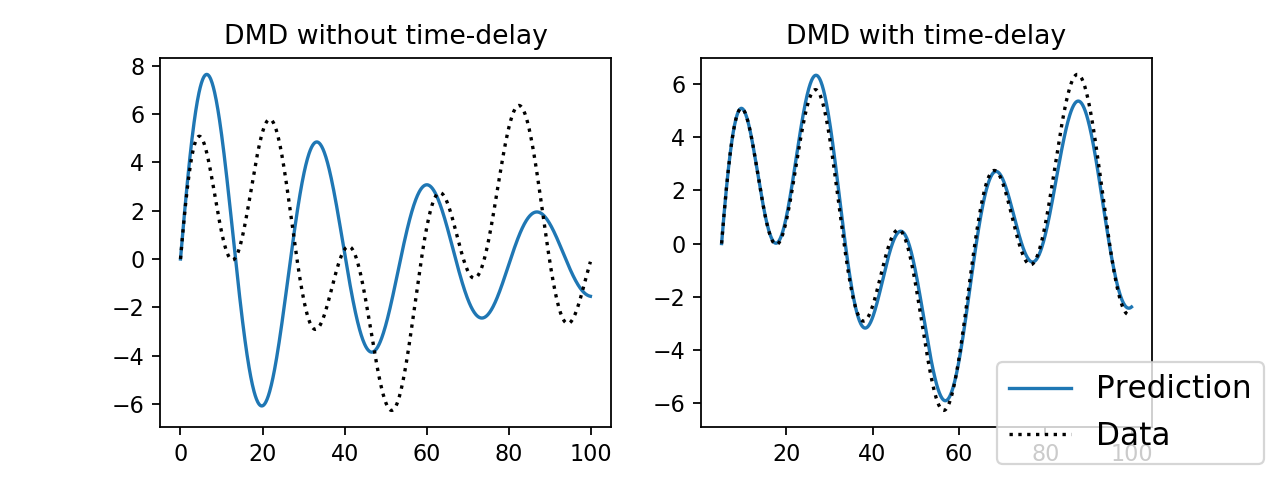

In [12]:
smd.set_control(ts, 4*np.sin(0.1*ts)**3) # weird non-linear forcing
res = smd.simulate(y0, t_span, dt, True)

fig, axes = plt.subplots(1,2,figsize=[8,3])
dmd = DMD.DMD.from_full(res.y, res.t)
# Ironically, the best fit linear operator looks like the underlying dynamics.
axes[0].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0],  ls=':', c='k')
axes[0].set_title('DMD without time-delay')

# Delay embed to capture extra control frequencies? Needs a bunch...
s = 50
dmd = DMD.DMD.from_full(DMD.delay_embed(res.y, s), res.t[s:])
axes[1].plot(ts[s:], dmd.predict(ts[s:])[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0],  ls=':', c='k')
axes[1].set_title('DMD with time-delay')

fig.legend(['Prediction', 'Data'], fontsize=14, loc='lower right', ncol=1)

Now let's have DMDc go to work on the same data. No time-delays needed and we get the underlying dynamics. Compare this result to the previous one without DMDc.

<IPython.core.display.Javascript object>


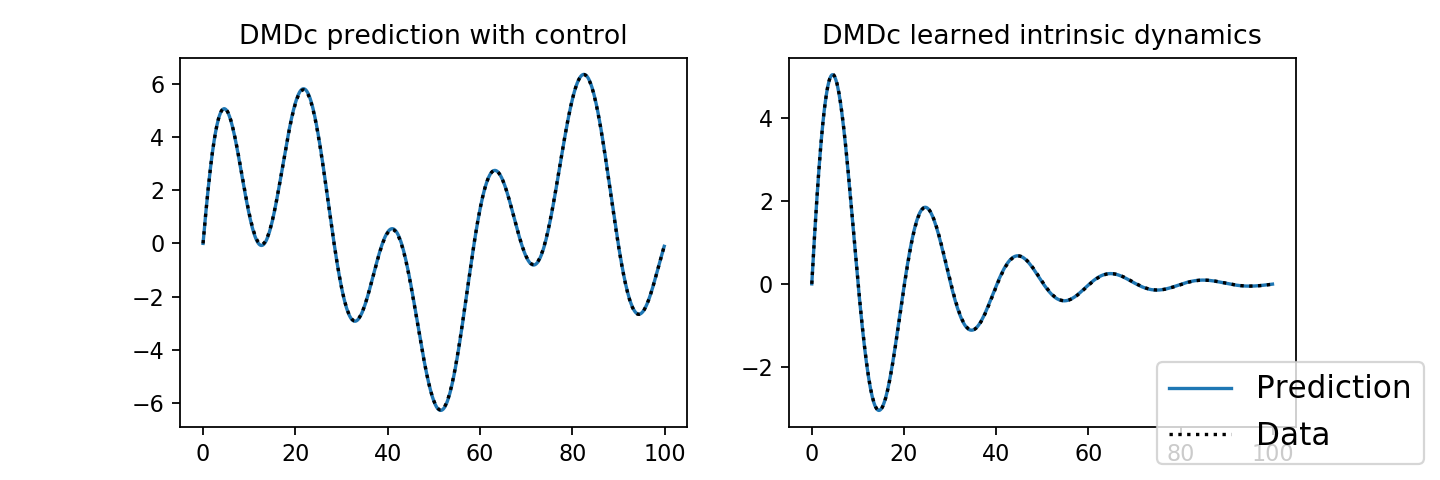

Equal dynamics? True


In [66]:
smd.set_control(ts, (4*np.sin(0.1*ts)**3).reshape(1,-1)) # weird non-linear forcing
res = smd.simulate(y0, t_span, dt, True)
X = res.y
U = smd.u(res.t)

dmdc = DMD.DMDc.from_full(X, U, res.t)

fig, axes = plt.subplots(1,2,figsize=[9,3])
axes[0].plot(dmdc.orig_timesteps, 
             dmdc.predict_dst()[0,:],  c=color[0])
axes[0].plot(dmdc.orig_timesteps, dmdc.X1[0,:],  ls=':', c='k')
axes[0].set_title('DMDc prediction with control')

smd.set_control(ts, np.zeros_like(ts))
res0 = smd.simulate(y0, t_span, dt, True)
axes[1].plot(dmdc.orig_timesteps, 
             dmdc.predict_dst(dmdc.zero_control())[0,:].real, c=color[0])
axes[1].plot(res0.t, res0.y[0,:], ls=':', c='k')
axes[1].set_title('DMDc learned intrinsic dynamics')

fig.legend(['Prediction', 'Data'], fontsize=14, loc='lower right', ncol=1)
print('Equal dynamics? ' + str(np.allclose(dmdc.A, sp.linalg.expm(smd.A*dt), atol=1e-3)))

# Derivative Example

We can also use DMD when the left hand side is a derivative. That is, if we want to solve
\[
    \dot{X} = A X + B U
\]
we just use the continuous prediction option in DMD.

<IPython.core.display.Javascript object>


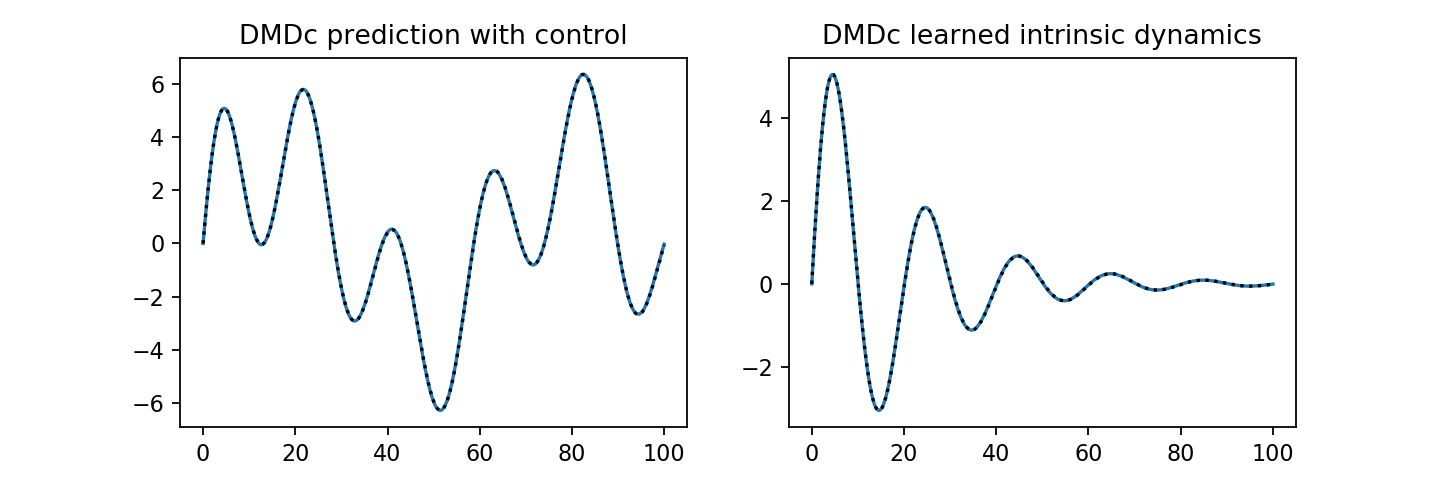

Text(0.5,1,'DMDc learned intrinsic dynamics')

In [69]:
# Choose times
t_span = [0,100]
ts = np.linspace(*t_span, 1000)
dt = ts[1]-ts[0]

# Initialize system
smd = eg.spring_mass_damper({'mass': 10, 'spring': 1, 'damper': 1})
y0 = np.array([0, 2]) # kick it

# Generate data
smd.set_control(ts, (4*np.sin(0.1*ts)**3).reshape(1,-1)) # weird non-linear forcing
res = smd.simulate(y0, t_span, dt, True)
X = res.y
X_dot = np.gradient(X, dt, axis=1)
U = smd.u(res.t)

# Fit model
dmdc = DMD.DMDc(X_dot, X, U, res.t)

# Plot
fig, axes = plt.subplots(1,2,figsize=[9,3])
axes[0].plot(dmdc.orig_timesteps, 
             dmdc.predict_cts()[0,:],  c=color[0])
axes[0].plot(dmdc.orig_timesteps,
             dmdc.X1[0,:],  ls=':', c='k')
axes[0].set_title('DMDc prediction with control')

smd.set_control(ts, np.zeros_like(ts))
res0 = smd.simulate(y0, t_span, dt, True)
axes[1].plot(dmdc.orig_timesteps, 
             dmdc.predict_cts(dmdc.zero_control())[0,:].real, c=color[0])
axes[1].plot(res0.t, res0.y[0,:], ls=':', c='k')
axes[1].set_title('DMDc learned intrinsic dynamics')